In [154]:
import torch
import torch.nn as nn
import numpy as np

np.random.seed(0)
torch.manual_seed(0)

def prepare(sequence):
    SEQ_LENGTH = sequence
    data = np.load("1.npy")
    testdata = np.load("1.npy")

    datapoints = len(data)

    data = data[:int(datapoints * 0.7)]
    testdata = testdata[int(datapoints * 0.7):]

    data = (data - np.mean(data)) / np.std(data)

    def create_sequences(data, testdata, seq_length):
        xs = []
        ys = []
        tests = []
        for i in range(len(data) - seq_length):
            x = data[i: (i + seq_length)] # 20 datapoints
            y = data[i + seq_length] # 21st datapoint
            test = testdata[i: (i + seq_length)]
            
            if i + seq_length <= len(testdata):
                test = testdata[i: (i + seq_length)]
                tests.append(test)
            xs.append(x)
            ys.append(y)
        
        return np.array(xs), np.array(ys), np.array(tests)

    X, y, TEST = create_sequences(data, testdata, SEQ_LENGTH,)

    TRAIN_X = torch.tensor(X[:, :, None], dtype=torch.float32)
    TRAIN_Y = torch.tensor(y[:, None], dtype=torch.float32)

    TEST_X = torch.tensor(TEST[:, :, None], dtype=torch.float32)

    return TRAIN_X, TRAIN_Y, TEST_X

In [155]:
TRAIN_X, TRAIN_Y, TEST_X = prepare(5)

In [156]:
TEST_X.shape, TRAIN_X.shape

(torch.Size([296, 5, 1]), torch.Size([694, 5, 1]))

In [157]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0 = None, c0 = None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [158]:
def define_model(hidden, learning):
    model = LSTMModel(input_dim = 1, hidden_dim = hidden, layer_dim = 1, output_dim = 1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning)

    return model, criterion, optimizer

In [159]:
def train(model, criterion, optimizer, TRAIN_X, TRAIN_Y, epochs):
    num_epochs = epochs
    h0, c0 = None, None

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs, h0, c0 = model(TRAIN_X, h0, c0)

        loss = criterion(outputs, TRAIN_Y)
        loss.backward()
        optimizer.step()

        h0 = h0.detach()
        c0 = c0.detach()

    return h0, c0

In [160]:
def test(model, TRAIN_X, TRAIN_Y, h0, c0):
    model.eval()
    predicted, _, _ = model(TRAIN_X, h0, c0)

    predicted = predicted.detach().numpy()

    return np.sqrt(np.mean((predicted.flatten() - TRAIN_Y.flatten().numpy())**2))
    

In [99]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

results = np.zeros((len(epochs), len(sequences), len(hidden), len(learning)))

for epoch_index in range(len(epochs)):
    for sequence_index in range(len(sequences)):
        for hidden_index in range(len(hidden)):
            for learning_index in range(len(learning)):
                TRAIN_X, TRAIN_Y, dataset = prepare(sequences[sequence_index])
                model, criterion, optimizer = define_model(hidden[hidden_index], learning[learning_index])
                h0, c0 = train(model, criterion, optimizer, TRAIN_X, TRAIN_Y, epochs[epoch_index])

                rsme = test(model, TRAIN_X, TRAIN_Y, h0, c0)

                results[epoch_index][sequence_index][hidden_index][learning_index] = rsme

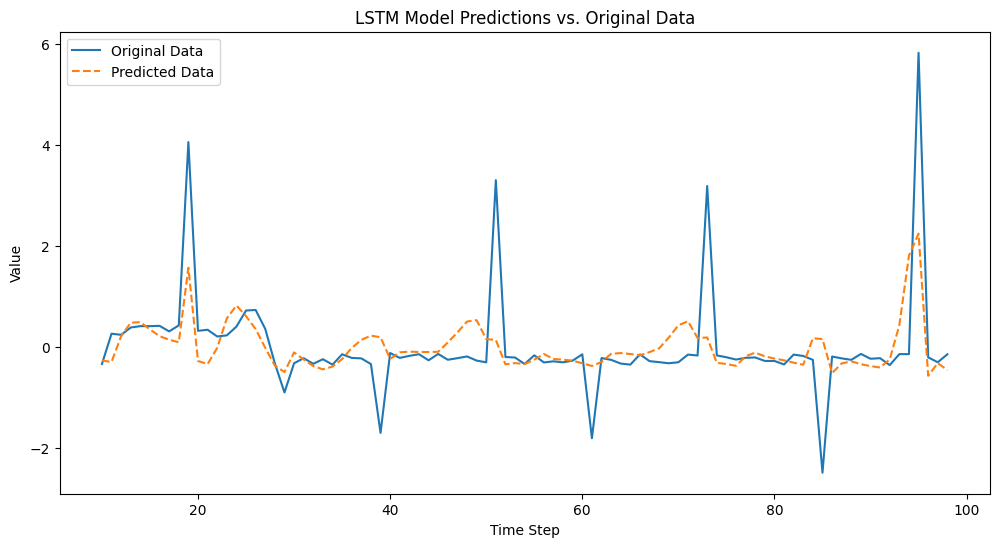

In [92]:
import matplotlib.pyplot as plt

def visualize(model, TRAIN_X, h0, c0, data, seq_length):
    model.eval()
    predicted, _, _ = model(TRAIN_X, h0, c0)

    predicted = predicted.detach().numpy()

    original = data[seq_length:]
    time_steps = np.arange(seq_length, len(data))

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, original, label='Original Data')
    plt.plot(time_steps, predicted, label='Predicted Data', linestyle='--')
    plt.title('LSTM Model Predictions vs. Original Data')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

visualize(model, TRAIN_X, h0, c0, dataset, 10)

In [69]:
rsme

0.7680221

In [103]:
results[0].shape

(4, 5, 4)

In [ ]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

# 100 epochs
results[0]

# 0.739133 at 100 epochs with 15 sequence_length 100 hidden layers and learning rate of .01

array([[[0.90597761, 0.94364065, 1.0139538 , 1.02124965],
        [1.02073634, 0.97129798, 1.01264536, 1.01946974],
        [0.95992821, 0.97677422, 1.01061332, 1.01753294],
        [0.9900527 , 0.97885728, 1.01886475, 1.01828647],
        [1.02406514, 0.98451835, 1.01001751, 1.01645851]],

       [[0.88393754, 0.93167847, 0.98932147, 1.01135695],
        [0.98857117, 0.97826695, 0.99085706, 1.00742388],
        [0.94692034, 0.92664522, 0.98705798, 1.00670695],
        [1.00695765, 0.89918274, 1.00291419, 1.00662255],
        [0.94421947, 0.95384675, 0.98051971, 1.00544095]],

       [[0.48408106, 0.83012229, 0.99265599, 1.03967583],
        [0.92595387, 0.739133  , 0.98188835, 1.03530824],
        [0.9526751 , 0.79939443, 0.98096615, 1.03338099],
        [0.96508473, 1.03112352, 0.9903003 , 1.02736223],
        [1.02023256, 0.80130768, 0.99655235, 1.02031958]],

       [[0.95463562, 0.84883595, 0.94590759, 0.96140963],
        [0.88468558, 0.95798331, 0.83214778, 0.96129113],
        

In [ ]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

# 200 epochs
results[1]

# 0.61818993 at 200 epochs with 10 sequence_length 50 hidden layers and learning rate of .01

array([[[0.96583182, 0.95676762, 0.99678689, 1.01860082],
        [0.94595242, 0.95844024, 1.01252508, 1.01538181],
        [0.92222923, 0.83506799, 1.00048685, 1.01506305],
        [1.02383196, 0.96347028, 0.99560392, 1.01397526],
        [1.0166322 , 0.97828978, 1.01657557, 1.01373351]],

       [[0.84089839, 0.61818993, 0.93846381, 1.00750971],
        [0.75195038, 0.86349249, 0.94650531, 1.00550306],
        [0.95807254, 0.94002146, 0.90628725, 0.98710692],
        [1.01427698, 0.92139095, 0.95383203, 0.98686934],
        [1.01400459, 1.14515734, 0.97338635, 0.9901495 ]],

       [[0.98866445, 0.76739812, 0.91687828, 1.03266025],
        [0.96007961, 0.96130532, 0.87863791, 1.02748811],
        [0.64758772, 0.84115762, 0.92310417, 1.0016824 ],
        [0.91157812, 0.71045554, 0.9807806 , 0.98095506],
        [1.03105843, 0.97820085, 0.89412791, 0.98409462]],

       [[0.77155519, 0.76824307, 0.8301456 , 0.96104985],
        [0.81022894, 0.95264685, 0.86439341, 0.96031618],
        

In [ ]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

# 300 epochs
results[2]

# 0.07704759 at 300 epochs with 15 sequence_length 100 hidden layers and learning rate of .1

array([[[0.86529404, 0.91559988, 0.98882657, 1.01505101],
        [0.93744242, 0.74652117, 0.99239671, 1.00167453],
        [1.0230906 , 0.87677616, 0.98940682, 1.02318859],
        [0.96929282, 0.86885959, 0.99130464, 1.02047586],
        [1.02396429, 0.83058888, 0.97209907, 1.14749539]],

       [[0.88246918, 0.58730048, 0.88522029, 1.00520551],
        [0.92454439, 0.87544358, 0.90523922, 0.99151415],
        [0.86192966, 0.6469844 , 0.94513756, 0.98387575],
        [0.97830075, 0.77436483, 0.88592207, 0.97887528],
        [0.82929146, 0.69614965, 0.97256154, 0.98133594]],

       [[0.95970362, 0.30953723, 0.87172818, 1.03498268],
        [0.07704759, 0.31178319, 0.93141401, 1.00476503],
        [0.39905468, 0.20130691, 0.86016321, 0.97664237],
        [1.04134476, 0.11933544, 0.80813885, 0.96806473],
        [1.01171327, 0.9371748 , 0.83873618, 0.97664142]],

       [[0.63730812, 0.68852448, 0.7803998 , 0.92539364],
        [0.8801825 , 0.66779101, 0.69863343, 0.91902298],
        

In [ ]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

# 400 epochs
results[3]

# 0.02648036 at 400 epochs with 15 sequence_length 200 hidden layers and learning rate of .01

array([[[0.56286275, 0.63248348, 0.98081237, 1.0083698 ],
        [0.87634301, 0.7391789 , 0.98747796, 1.01441193],
        [1.02143717, 0.92114133, 1.01429355, 1.01196492],
        [0.97759241, 0.67224687, 0.96921867, 1.01303279],
        [0.92716181, 0.91557652, 0.96601355, 1.01334023]],

       [[0.51647145, 0.78703558, 0.90351266, 0.98267031],
        [0.850896  , 1.08262658, 0.83675861, 0.97860605],
        [0.6020788 , 0.45053452, 0.67638952, 0.97667032],
        [0.98176748, 0.68762171, 0.77453703, 0.96900064],
        [1.00791633, 0.68797797, 0.717327  , 0.97889584]],

       [[0.12951402, 0.53789586, 0.85270786, 0.98237467],
        [0.99132091, 0.24681304, 0.84923536, 0.99129951],
        [0.97770858, 0.16848861, 0.84279263, 0.96670133],
        [1.02936339, 0.02648036, 0.88024706, 0.95273077],
        [1.01831865, 0.13918926, 0.79852432, 0.98821902]],

       [[0.5439015 , 0.19254327, 0.83579522, 0.95889628],
        [0.62203699, 0.3010737 , 0.62926745, 0.89205325],
        

In [ ]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

# 500 epochs
results[4]

# 0.03323467 at 500 epochs with 15 sequence_length 250 hidden layers and learning rate of .01

array([[[0.56844538, 0.84608942, 0.992935  , 1.00838935],
        [0.60477883, 0.66154087, 0.97447121, 1.00558364],
        [0.81023729, 0.85294658, 0.9566043 , 1.00624061],
        [0.99439365, 0.75804937, 0.95997143, 1.01348376],
        [0.90284753, 0.82993859, 0.97957122, 1.00965321]],

       [[0.1797054 , 0.64076561, 0.74027121, 0.97306883],
        [0.24286784, 0.56415516, 0.61410677, 0.97162551],
        [0.63172817, 0.86580199, 0.62548846, 0.96028787],
        [0.94317961, 0.66846877, 0.68938339, 0.96704328],
        [0.96713376, 0.67716378, 0.81230277, 0.96462637]],

       [[0.74604607, 0.28584483, 0.75566113, 0.97063226],
        [0.92636102, 0.19226308, 0.79966784, 1.01264572],
        [0.58495623, 0.17152691, 0.87240869, 0.95065111],
        [0.98052955, 0.03585071, 0.98780918, 0.93593508],
        [0.77797979, 0.03323467, 0.70661932, 1.05129051]],

       [[0.72438288, 0.63026166, 0.74302876, 0.89507395],
        [0.70964766, 0.67470407, 0.61271644, 0.90063679],
        

In [161]:
# 0.02648036 at 400 epochs with 15 sequence_length 200 hidden layers and learning rate of .01

TRAIN_X, TRAIN_Y, TEST_X = prepare(5)
model, criterion, optimizer = define_model(200, 0.01)
h0, c0 = train(model, criterion, optimizer, TRAIN_X, TRAIN_Y, 400)

rsme = test(model, TRAIN_X, TRAIN_Y, h0, c0)

In [162]:
rsme

0.90548736

In [ ]:
import matplotlib.pyplot as plt

def visualize(model, h0, c0, data, seq_length, TEST_X):
    model.eval()
    predicted, _, _ = model(TEST_X, h0, c0)

    predicted = predicted.detach().numpy()

    original = data[seq_length:]
    time_steps = np.arange(seq_length, len(data))

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, original, label='Original Data')
    plt.plot(time_steps, predicted, label='Predicted Data', linestyle='--')
    plt.title('LSTM Model Predictions vs. Original Data')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

visualize(model, h0, c0, dataset, 15, TEST_X)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'